# Final Highway Network Experiment Analysis
This one doesn't use the increase_ego_reward_importance setting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import os
import matplotlib.pyplot as plt
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from src.utils import calc_hypervolume

## Loading the data

In [3]:
def load_merged_dataframe(literal_str):
    file_list = glob.glob(literal_str)
    df = pd.concat(map(pd.read_csv, file_list), ignore_index=True)
    return df

In [4]:
#load the data
#first two configs
summary_files = os.path.join("data/moma_highway_test_final/", "moma_highway_final*summary.csv")
detail_files = os.path.join("data/moma_highway_test_final/", "moma_highway_final*detail.csv")
loss_files = os.path.join("data/moma_highway_test_final/", "moma_highway_final*loss.csv")

df_summary = load_merged_dataframe(summary_files)
df_detail = load_merged_dataframe(detail_files)
df_loss = load_merged_dataframe(loss_files)

#last config
summary_last_config = pd.read_csv("data/moma_highway_test_final_3rd_config/moma_highway_final_3rd_config_merged_summary.csv")
summary_last_config["env_config_id"] = 2

detail_last_config = pd.read_csv("data/moma_highway_test_final_3rd_config/moma_highway_final_3rd_config_merged_detail.csv")
detail_last_config["env_config_id"] = 2

loss_last_config = pd.read_csv("data/moma_highway_test_final_3rd_config/moma_highway_final_3rd_config_merged_loss.csv")
loss_last_config["env_config_id"] = 2

In [5]:
# combine the experiments of all configs
df_summary = pd.concat([df_summary, summary_last_config], ignore_index=True)
df_detail = pd.concat([df_detail, detail_last_config], ignore_index=True)
df_loss = pd.concat([df_loss, loss_last_config], ignore_index=True)

In [6]:
print("Summary:")
df_summary.info()
print("Detail:")
df_detail.info()
print("Loss")
df_loss.info()

Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                28800 non-null  int64  
 1   repetition_number         28800 non-null  int64  
 2   weight_index              28800 non-null  int64  
 3   weight_tuple              28800 non-null  object 
 4   num_iterations            28800 non-null  int64  
 5   vehicle_id                28800 non-null  int64  
 6   normalised_speed_reward   28800 non-null  float64
 7   normalised_energy_reward  28800 non-null  float64
 8   raw_speed_reward          28800 non-null  float64
 9   raw_energy_reward         28800 non-null  float64
 10  env_config_id             28800 non-null  int64  
 11  experiment_id             28800 non-null  int64  
 12  replay_buffer_size        28800 non-null  int64  
 13  batch_size                28800 non-null  int64  
 1

## Data Preprocessing

In [7]:
df_summary["env_config_id"].value_counts()

env_config_id
2    16800
1     9600
0     2400
Name: count, dtype: int64

In [8]:
# add controlled vehicle ratio
df_summary["controlled_vehicle_ratio"] = 0.0
df_summary.loc[df_summary["env_config_id"] == 0, "controlled_vehicle_ratio"] = 2/20
df_summary.loc[df_summary["env_config_id"] == 1, "controlled_vehicle_ratio"] = 8/20
df_summary.loc[df_summary["env_config_id"] == 2, "controlled_vehicle_ratio"] = 14/20
df_summary["controlled_vehicle_ratio"].value_counts()

controlled_vehicle_ratio
0.7    16800
0.4     9600
0.1     2400
Name: count, dtype: int64

In [9]:
#exclude the suffix "reward" for entries the reward structure column
df_summary["reward_structure"] = df_summary["reward_structure"].apply(lambda row: row.split("_")[0])

#remap the use_multi_dqn column to explicitly state the employed reward structure
df_summary["use_multi_dqn"] = df_summary["use_multi_dqn"].astype(str)
df_summary.loc[df_summary["use_multi_dqn"] == "False","use_multi_dqn"] = "basic"
df_summary.loc[df_summary["use_multi_dqn"] == "True","use_multi_dqn"] = "separated"

In [10]:
print(df_summary["reward_structure"].value_counts())
print(df_summary["use_multi_dqn"].value_counts())

reward_structure
mean    19200
ego      9600
Name: count, dtype: int64
use_multi_dqn
basic        19200
separated     9600
Name: count, dtype: int64


In [11]:
# add experiment configuration name
df_summary["alg_config"] = df_summary.apply(lambda row : f"NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
print(df_summary["alg_config"].value_counts())

df_summary["exp_config"] = df_summary.apply(lambda row : f"CVR_{row["controlled_vehicle_ratio"]}_NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
print(df_summary["exp_config"].value_counts())

alg_config
NS_basic_RS_mean        9600
NS_basic_RS_ego         9600
NS_separated_RS_mean    9600
Name: count, dtype: int64
exp_config
CVR_0.7_NS_basic_RS_mean        5600
CVR_0.7_NS_basic_RS_ego         5600
CVR_0.7_NS_separated_RS_mean    5600
CVR_0.4_NS_basic_RS_mean        3200
CVR_0.4_NS_basic_RS_ego         3200
CVR_0.4_NS_separated_RS_mean    3200
CVR_0.1_NS_separated_RS_mean     800
CVR_0.1_NS_basic_RS_mean         800
CVR_0.1_NS_basic_RS_ego          800
Name: count, dtype: int64


## Data Analysis

### Pareto front estimation

Text(0.5, 0, 'Normalised Speed Reward')

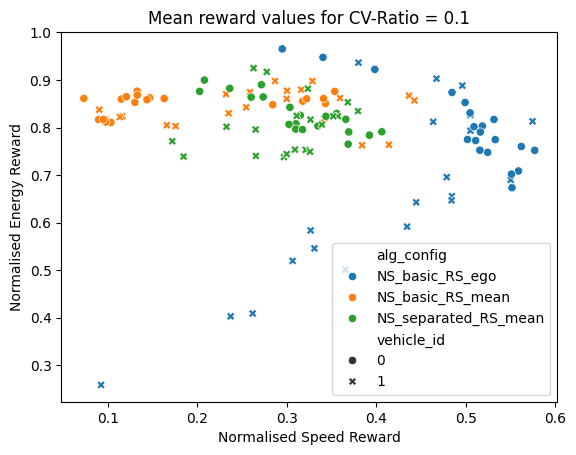

In [12]:
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","weight_index", "vehicle_id"])[["normalised_energy_reward", "normalised_speed_reward"]].mean()
ax = sns.scatterplot(grouped_df, x="normalised_speed_reward", y="normalised_energy_reward", style="vehicle_id",hue="alg_config")
ax.set_title("Mean reward values for CV-Ratio = 0.1")
ax.set_ylabel("Normalised Energy Reward")
ax.set_xlabel("Normalised Speed Reward")

This plot shows how for this specific cv ratio, the baseline algorithm does best, supposedly because they only care about their own reward. For the mean algo's on the other hand, the vehicle rewards have a lower variance because they care about the rewards of other vehicles as well. If that first impression holds, we will see when looking at the boxplots.

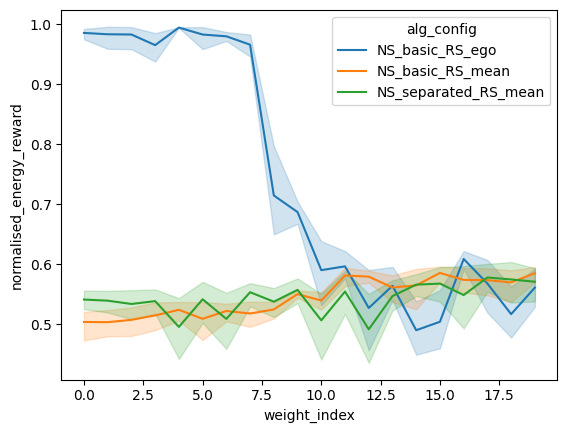

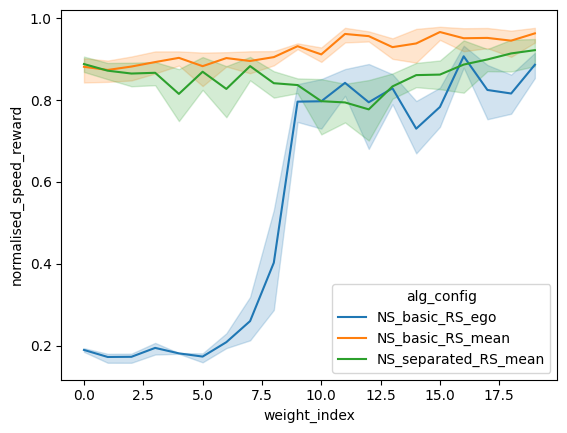

In [29]:
#TODO: two lineplots: one for the energy reward, one for the speeds reward chosing how they change when increasing the preference for speed, i.e. weight index on the x-axis
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.4].groupby(["alg_config","weight_index", "vehicle_id"])[["normalised_energy_reward","normalised_speed_reward"]].mean()
sns.lineplot(grouped_df, x="weight_index", y="normalised_energy_reward", hue="alg_config")
plt.show()
sns.lineplot(grouped_df, x="weight_index", y="normalised_speed_reward", hue="alg_config")
plt.show()

#0.4 ratio

The ego one does way better than the mean ones in producing very different policies when changing the preferences. This can be attributed to them not caring about other vehicles. The mean ones on the other hand have a much more subtle change in rewards when changing the weight index. This might be caused by several factors. First off, they care about the other vehicle's returns, so they might use different actions because it would increase the mean utility for the close vehicles. Interestingly, when increasing the ratio of vehicles that are controlled to 0.7, the ego algorithm behaves the same, which might be because the controlled vehicles are actually impeding with each other, everyone trying to get out on top (indicated by the high variation is speeds), while the variance for the mean algorithms, the mean separated one in particular, are much lower. This indicates that is has an easier time accurately assessing the social q-values for the close vehicles.

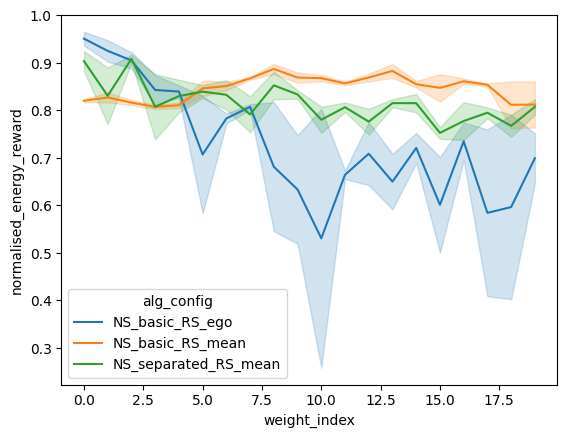

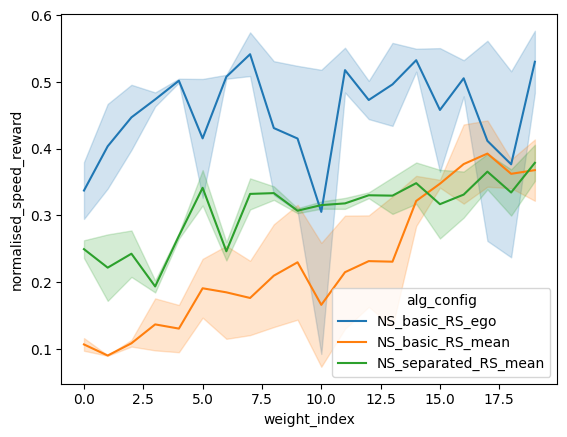

In [30]:
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","weight_index", "vehicle_id"])[["normalised_energy_reward","normalised_speed_reward"]].mean()
sns.lineplot(grouped_df, x="weight_index", y="normalised_energy_reward", hue="alg_config")
plt.show()
sns.lineplot(grouped_df, x="weight_index", y="normalised_speed_reward", hue="alg_config")
plt.show()

#0.4 ratio

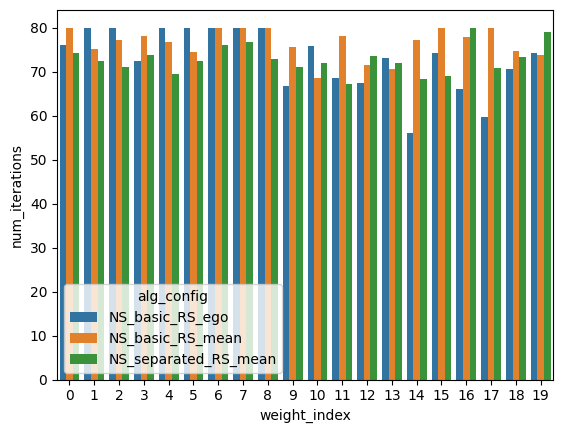

In [31]:
#TODO: num iterations before a crash
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.4].groupby(["alg_config","weight_index", "vehicle_id"])[["num_iterations"]].mean()
sns.barplot(grouped_df, x="weight_index", y="num_iterations", hue="alg_config")
plt.show()

All approximately the same

### Plots of hypervolume distribution among vehicles of the same experiment

In [54]:
#compute hypervolume for all vehicles
hv_data = []
grouped_data = df_summary.groupby(["controlled_vehicle_ratio","alg_config","vehicle_id"])
for (cvr, alg_config, vehicle_id), group in grouped_data:
    group_data = group[["normalised_speed_reward","normalised_energy_reward"]].to_numpy()
    hv = calc_hypervolume(reward_vector=group_data)
    hv_data.append({"controlled_vehicle_ratio": cvr, "alg_config":alg_config, "vehicle_id": vehicle_id, "hypervolume":hv})

hv_df = pd.DataFrame(hv_data)
display(hv_df)
#TODO: construct scatterplot and then boxplot of the hypervolumes for the vehicles grouped by ratio of controlled vehicles and by reward/network structure
#compute hypervolume



,controlled_vehicle_ratio,alg_config,vehicle_id,hypervolume
0,0.1,NS_basic_RS_ego,0,0.698634
1,0.1,NS_basic_RS_ego,1,0.764246
2,0.1,NS_basic_RS_mean,0,0.585965
3,0.1,NS_basic_RS_mean,1,0.579302
4,0.1,NS_separated_RS_mean,0,0.521843
...,...,...,...,...
67,0.7,NS_separated_RS_mean,9,0.633373
68,0.7,NS_separated_RS_mean,10,0.648051
69,0.7,NS_separated_RS_mean,11,0.645569
70,0.7,NS_separated_RS_mean,12,0.640710


<Axes: xlabel='controlled_vehicle_ratio', ylabel='hypervolume'>

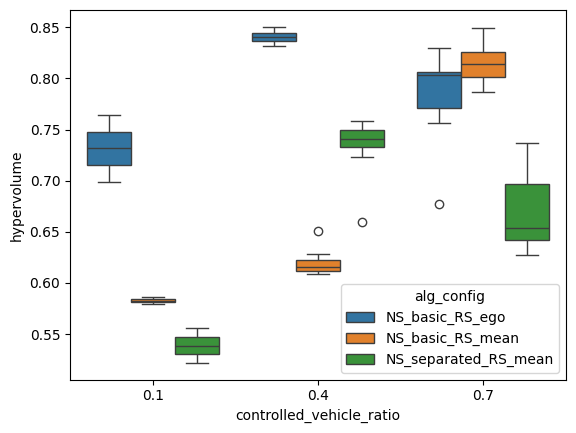

In [55]:
sns.boxplot(hv_df, x="controlled_vehicle_ratio", y="hypervolume", hue="alg_config")
#TODO: hypothesis: the hypervolume is dependent on the vehicle id, 
# because of they way they are spawned (one vehicle is always first, 
# has an easier time optimising their reward as they don't have as many vehicles to overtake): 
# color the dots in the scatterplot by the vehicle_id to see if there is. 
# If that is to messy to see something, try using a barplot/lineplot 
# with the vehicle ID on the x axis and the hypervolume on the y axis

<Axes: xlabel='controlled_vehicle_ratio', ylabel='hypervolume'>

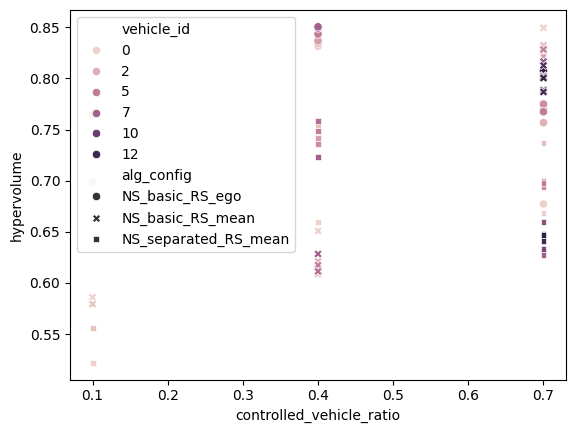

In [57]:
sns.scatterplot(hv_df, x="controlled_vehicle_ratio", y="hypervolume", hue="vehicle_id", style="alg_config")

In [ ]:
#TODO: look at how the loss (and maybe the hypervolume) changes while training for all the algorithm configurations